## SelectFeatures
This notebook shows the development of how we select important features from `ChemFeatures` to study with. We used the following method to analyze the weight of each feature:

* LASSO (Least Absolute Shrinkage and Selection Operator)
* RFE (Recursive Feature Elimination)
* RIDGE (Ridge Regression)
* SS (Stability Selection)

We use explained variance to compare and evaluate these methods for final decision making.<br>

#### Use ``ChemFeatures`` to generate a dataframe of features.

In [2]:
import pandas as pd
# Module for extracting ChemInfo
from SeekFeatures import ChemFeatures
import mordred
import sklearn

# plotting package
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Use 100K data for demonstration
data = pd.read_csv('../Database/HCEPD_100K.csv') 
# Use first 50 data to illustrate the analysis
data50 = data.head(50)
data50.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


Generate a dataframe of chemical features.

In [4]:
features_df = ChemFeatures(data50['SMILES_str'])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  8.32it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


In [5]:
features_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,20.142136,16.169815,0,0,33.204238,2.616114,5.057172,33.204238,1.383510,4.188377,...,10.460213,77.559765,394.963154,11.968580,1216,42,146.0,185.0,4.611111,5.000000
1,20.849242,16.133746,0,0,34.755190,2.600656,5.047921,34.755190,1.390208,4.221130,...,10.493799,77.890806,401.013897,10.025347,1337,45,150.0,189.0,4.861111,5.250000
2,22.889683,17.893320,0,0,37.437727,2.645420,5.160050,37.437727,1.386582,4.315006,...,10.639862,82.032579,363.107941,8.252453,1635,49,168.0,215.0,5.083333,5.555556
3,13.313708,11.688393,0,0,21.283525,2.481194,4.637583,21.283525,1.330220,3.777767,...,9.782393,66.966647,319.941201,11.426471,430,20,94.0,115.0,3.166667,3.333333
4,19.435029,15.989365,0,0,31.670490,2.627835,5.062549,31.670490,1.376978,4.154569,...,10.429310,77.119188,379.977407,10.856497,1074,39,142.0,181.0,4.361111,4.750000


In [7]:
features_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,20.142136,16.169815,0,0,33.204238,2.616114,5.057172,33.204238,1.383510,4.188377,...,10.460213,77.559765,394.963154,11.968580,1216,42,146.0,185.0,4.611111,5.000000
1,20.849242,16.133746,0,0,34.755190,2.600656,5.047921,34.755190,1.390208,4.221130,...,10.493799,77.890806,401.013897,10.025347,1337,45,150.0,189.0,4.861111,5.250000
2,22.889683,17.893320,0,0,37.437727,2.645420,5.160050,37.437727,1.386582,4.315006,...,10.639862,82.032579,363.107941,8.252453,1635,49,168.0,215.0,5.083333,5.555556
3,13.313708,11.688393,0,0,21.283525,2.481194,4.637583,21.283525,1.330220,3.777767,...,9.782393,66.966647,319.941201,11.426471,430,20,94.0,115.0,3.166667,3.333333
4,19.435029,15.989365,0,0,31.670490,2.627835,5.062549,31.670490,1.376978,4.154569,...,10.429310,77.119188,379.977407,10.856497,1074,39,142.0,181.0,4.361111,4.750000


> Not all molecules have the same features as others, so there will be some non-value entries hidden in the dataframe.

In [8]:
# find the non-value entries.

missing =[]
for i in range(features_df.shape[1]):
    if type(features_df.loc[1][i]) == mordred.error.Missing:
        missing.append(features_df.loc[1][i])

# show examples of the non-value entries.        
missing[0:5]

In [9]:
import numpy as np
assd = features_df.dtypes
type(assd[1])

numpy.dtype

> **for these non-value entries, we assign them to 0, simply indicating that the molecule does not possess that specific feature.**

In [20]:
# replace missing value(wrong type) with 0
type_series = features_df.dtypes
wrong_column = []
for col in range(len(type_series)):
    if type_series[col] != np.float64 and type_series[col] != np.int64:
        wrong_column.append(col)
for column in wrong_column:
    i = 0
    for item in features_df.iloc[:,column]:
        if type(item) != np.float64 and type(item) != np.int64:
            features_df.iloc[i,column] = 0
        i += 1    

In [22]:
from sklearn.preprocessing import StandardScaler
features =[feature for feature in features_df.columns]

# Separating out the features
x = features_df.loc[:, features].values

# Our target is pce
y = data50['pce'].values
sc = StandardScaler()
X = sc.fit_transform(x)

c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
features = [ftr for ftr in features_df.head()]
ranks = {}
def rank_to_dict(ranks, names, order=1):
    sc = StandardScaler()
    ranks = sc.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
estimatorREFCV = SVR('linear')
selectorREFCV = RFECV(estimatorREFCV, step=5, scoring='explained_variance')
selectorREFCV.fit(X, y)

c:\users\alex0\anaconda3\envs\pvc-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RFECV(cv='warn',
   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
   min_features_to_select=1, n_jobs=None, scoring='explained_variance',
   step=5, verbose=0)

Optimal number of features : 60
[False False False ... False False False]


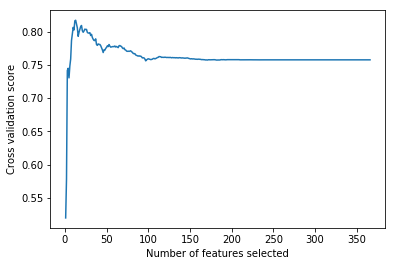

In [24]:
print("Optimal number of features : %d" % selectorREFCV.n_features_)
print(selectorREFCV.support_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selectorREFCV.grid_scores_) + 1), selectorREFCV.grid_scores_)
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

X_train, X_test, y_Train, y_test = train_test_split(X, y, test_size = 0.25)

In [41]:
X_train

array([[ 0.52500823,  0.95512193,  0.        , ...,  0.65133964,
         0.37360071,  0.44891599],
       [ 1.87156807,  1.71608382,  0.        , ...,  1.84703559,
         1.8835343 ,  1.88242924],
       [-1.23987412, -1.10576625,  0.        , ..., -1.26806703,
        -1.09319192, -1.09776935],
       ...,
       [-0.10901784, -0.31107999,  0.        , ..., -0.22969949,
         0.02847303, -0.04149644],
       [-0.35089064, -0.16678852,  0.        , ..., -0.32409653,
        -0.3597956 , -0.3432887 ],
       [-0.35089064, -0.26438086,  0.        , ..., -0.32409653,
        -0.3597956 , -0.3432887 ]])

In [49]:
# RR vs lambda (based on sklearn tutorial)
coefs = []
trainerror = []
testerror = []

# do you know what is happening here? 
lambdas = np.logspace(-6,10,200)
model=Ridge()

# loop over lambda values (strength of regularization)
for l in lambdas:
    model.set_params(alpha=l)
    model.fit(X_train,y_train)
    coefs.append(model.coef_)
    trainerror.append(mean_squared_error(y_train, model.predict(X_train)))
    testerror.append(mean_squared_error(y_test, model.predict(X_test)))

Text(0.5, 1.0, 'error vs $\\lambda$')

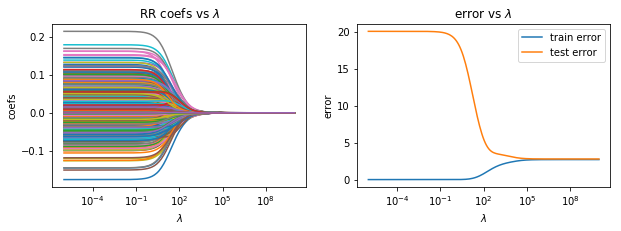

In [50]:
plt.figure(figsize=(10,3))
#plt.locator_params(nbins=5)
plt.subplot(121)
plt.plot(lambdas,coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefs')
plt.title('RR coefs vs $\lambda$')
#plt.xlim(1e-4,1e0)

plt.subplot(122)
plt.plot(lambdas,trainerror,label='train error')
plt.plot(lambdas,testerror,label='test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('error')
#plt.xlim(1e-3,1e4)
#plt.ylim(0,0.5)
plt.legend(loc=1)
plt.title('error vs $\lambda$')

In [51]:
from sklearn.linear_model import RandomizedLogisticRegression as stability